In [ ]:
# !pip install torchsummary

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary

import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

BATCH_SIZE = 32

PyTorch Version:  2.7.1+cu128
Torchvision Version:  0.22.1+cu128


## Prepair Dataset

In [ ]:
!git clone https://github.com/hbcbh1999/recaptcha-dataset.git

Cloning into 'recaptcha-dataset'...
remote: Enumerating objects: 11754, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 11754 (delta 5), reused 1 (delta 0), pack-reused 11742
Receiving objects: 100% (11754/11754), 395.64 MiB | 28.70 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (11779/11779), done.


In [36]:
# !rm -rf ./recaptcha-dataset/Large/Mountain/
# !rm -rf ./recaptcha-dataset/Large/Other/
!rm -rf ./recaptcha-dataset/Large/readme.txt

ImageFolder structure

```
data_dir/Bicycle/xxx.png
data_dir/Bicycle/xxy.png
data_dir/Bicycle/[...]/xxz.png
...
data_dir/Traffic Light/123.png
data_dir/Traffic Light/nsdf3.png
data_dir/Traffic Light/[...]/asd932_.png
```



In [3]:
from sklearn.model_selection import StratifiedKFold

data_dir = "./recaptcha-dataset/Large"
class_names = ['Bicycle', 'Bridge', 'Bus', 'Car',
               'Chimney', 'Crosswalk', 'Hydrant',
               'Motorcycle', 'Palm', 'Traffic Light']

input_size = 224
batch_size = BATCH_SIZE
k_folds = 5
random_seed = 42


data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(input_size), 
    transforms.RandomHorizontalFlip(), 
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("Initializing Datasets and Dataloaders...")

image_datasets = datasets.ImageFolder(data_dir, data_transforms)
num_data = len(image_datasets)
targets = image_datasets.targets

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
splits = list(skf.split(np.zeros(num_data), targets))

val_dataloaders = []

for fold, (train_idx, val_idx) in enumerate(splits):
    train_set = torch.utils.data.Subset(image_datasets, train_idx)
    val_set = torch.utils.data.Subset(image_datasets, val_idx)

    dataloaders = {
        'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4),
        'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
    }

    val_dataloaders.append(dataloaders)

Initializing Datasets and Dataloaders...


In [4]:
def imshow(imgs, title=None):
    """Display image for Tensor."""
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


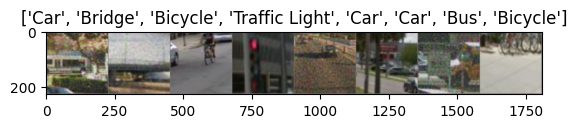

In [5]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


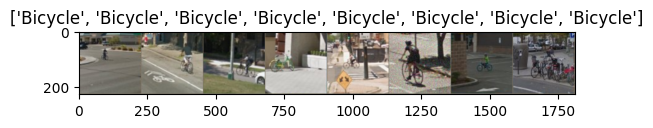

In [6]:
# Get a batch of validation data
inputs, labels = next(iter(dataloaders['val']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

## Build model

### ResNet from scratch

![resnet](https://pytorch.org/assets/images/resnet.png)

In [6]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [7]:
class ResNet_18(nn.Module):

    def __init__(self, image_channels, num_classes):

        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):

        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

In [8]:
model = ResNet_18(image_channels=3, num_classes=10)
summary(model, (3, 224, 224), device='cpu')
# summary(model, (3, 512, 512), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
            Block-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Resnet from model zoo

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [11]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

num_classes = 10
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
summary(model_ft, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Train model

In [15]:
print(torch.cuda.is_available())

True


In [12]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [14]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
# Setup the loss fxn
# criterion = nn.CrossEntropyLoss()

# Train and evaluate
# model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 1.1266 Acc: 0.6301
val Loss: 0.7699 Acc: 0.7494

Epoch 1/14
----------
train Loss: 0.7095 Acc: 0.7697
val Loss: 0.6617 Acc: 0.7882

Epoch 2/14
----------
train Loss: 0.6362 Acc: 0.7917
val Loss: 0.5993 Acc: 0.7882

Epoch 3/14
----------
train Loss: 0.5944 Acc: 0.8041
val Loss: 0.5638 Acc: 0.8101

Epoch 4/14
----------
train Loss: 0.5609 Acc: 0.8128
val Loss: 0.5875 Acc: 0.8135

Epoch 5/14
----------
train Loss: 0.5163 Acc: 0.8317
val Loss: 0.5703 Acc: 0.8125

Epoch 6/14
----------
train Loss: 0.4987 Acc: 0.8347
val Loss: 0.5649 Acc: 0.8159

Epoch 7/14
----------
train Loss: 0.4922 Acc: 0.8393
val Loss: 0.5298 Acc: 0.8344

Epoch 8/14
----------
train Loss: 0.4704 Acc: 0.8431
val Loss: 0.5158 Acc: 0.8383

Epoch 9/14
----------
train Loss: 0.4560 Acc: 0.8516
val Loss: 0.5420 Acc: 0.8184

Epoch 10/14
----------
train Loss: 0.4522 Acc: 0.8488
val Loss: 0.5092 Acc: 0.8227

Epoch 11/14
----------
train Loss: 0.4318 Acc: 0.8590
val Loss: 0.5529 Acc: 0.8222

Ep

In [16]:
criterion = nn.CrossEntropyLoss()
all_fold_acc = []

for fold, (train_idx, val_idx) in enumerate(splits):    
    model_ft, _ = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    model_ft = model_ft.to(device)

    train_set = torch.utils.data.Subset(image_datasets, train_idx)
    val_set = torch.utils.data.Subset(image_datasets, val_idx)
    dataloaders = {
        'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4),
        'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
    }

    params_to_update = model_ft.parameters()
    if feature_extract:
        params_to_update = [p for p in model_ft.parameters() if p.requires_grad]
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

    all_fold_acc.append(max(hist).item())

Epoch 0/14
----------
train Loss: 1.1311 Acc: 0.6329
val Loss: 0.7336 Acc: 0.7572

Epoch 1/14
----------
train Loss: 0.7404 Acc: 0.7567
val Loss: 0.6383 Acc: 0.7902

Epoch 2/14
----------
train Loss: 0.6435 Acc: 0.7860
val Loss: 0.5993 Acc: 0.8193

Epoch 3/14
----------
train Loss: 0.5705 Acc: 0.8093
val Loss: 0.5812 Acc: 0.8130

Epoch 4/14
----------
train Loss: 0.5648 Acc: 0.8094
val Loss: 0.5638 Acc: 0.8193

Epoch 5/14
----------
train Loss: 0.5453 Acc: 0.8193
val Loss: 0.5599 Acc: 0.8281

Epoch 6/14
----------
train Loss: 0.5065 Acc: 0.8314
val Loss: 0.5684 Acc: 0.8271

Epoch 7/14
----------
train Loss: 0.4960 Acc: 0.8340
val Loss: 0.5393 Acc: 0.8193

Epoch 8/14
----------
train Loss: 0.4852 Acc: 0.8411
val Loss: 0.5291 Acc: 0.8305

Epoch 9/14
----------
train Loss: 0.4640 Acc: 0.8449
val Loss: 0.5524 Acc: 0.8300

Epoch 10/14
----------
train Loss: 0.4694 Acc: 0.8460
val Loss: 0.5618 Acc: 0.8159

Epoch 11/14
----------
train Loss: 0.4341 Acc: 0.8563
val Loss: 0.5605 Acc: 0.8256

Ep

## Save the model & features

In [ ]:
# torch.save(model_ft.state_dict(), 'resnet18.pt')

In [17]:
torch.save(model_ft, 'resnet18_ft_a2.pt')

In [18]:
model_ft = torch.load('resnet18_ft_a2.pt', weights_only=False)
modules = list(model_ft.children())[:-1]
resnet18_feat = nn.Sequential(*modules).to(device)
resnet18_feat.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [20]:
all_features = []
all_labels = []

with torch.no_grad():
    for fold_idx, loaders in enumerate(val_dataloaders):
        for inputs, labels in loaders['val']:
            inputs = inputs.to(device)
            h = resnet18_feat(inputs)
            h = h.view(h.size(0), -1)  # [B, 512]
            
            all_features.append(h.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

os.makedirs('prepared_features', exist_ok=True)
np.save('prepared_features/val_features_resnet18_a2.npy', all_features)
np.save('prepared_features/val_labels_resnet18_a2.npy', all_labels)

In [21]:
resnet18_feat.eval()
val_features = np.load('prepared_features/val_features_resnet18_a2.npy')
val_labels = np.load('prepared_features/val_labels_resnet18_a2.npy')

# with torch.no_grad():
#     for fold_idx, loaders in enumerate(val_dataloaders):
#         for inputs, labels in loaders['val']:
#             inputs = inputs.to(device)
#             features = resnet18_feat(inputs)           # (B, 512, 1, 1)
#             features = features.view(features.size(0), -1)  # (B, 512)
#             val_features.append(features.cpu())
#             val_labels.append(labels.cpu())

# val_features = torch.cat(val_features, dim=0).numpy()
# val_labels = torch.cat(val_labels, dim=0).numpy()


### Prepare Test Dataset

In [22]:
test_dir = './testset'

test_transform = transforms.Compose([
transforms.Resize((input_size, input_size)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_paths = sorted([
    os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.lower().endswith('png')
])

In [23]:
import cv2
from PIL import Image

test_images = []
file_names = []

for path in image_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img = test_transform(img)

    test_images.append(img)
    file_names.append(os.path.basename(path))

test_tensor = torch.stack(test_images)
test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=BATCH_SIZE, shuffle=False)

resnet18_feat.eval()
test_features = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        feat = resnet18_feat(batch)
        feat = feat.view(feat.size(0), -1)
        test_features.append(feat.cpu())

test_features = torch.cat(test_features, dim=0).numpy()

### Task 1: Classification

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(val_features, val_labels)

pred_labels = knn.predict(test_features)

In [25]:
import csv

with open ('c2_t1_a2.csv', 'w') as file:
    writer = csv.writer(file)
    for fname, pred in zip(file_names, pred_labels):
        writer.writerow([fname, class_names[pred]])

### Task 2: Retrieval

In [26]:
# top-10 nearest neighbor indices
indices = knn.kneighbors(X=test_features, n_neighbors=10, return_distance=False)
neighbors = val_labels[indices]  # shape: (N, 10)

with open('c2_t2_a2.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for fname, neighbor in zip(file_names, neighbors):
        label_names = [class_names[label] for label in neighbor]
        writer.writerow([fname] + label_names)